<a href="https://colab.research.google.com/github/Aktuarius/MSBD-5008-Project/blob/main/5008_Project_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install dgl

# Load necessary packages
import dgl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
import random

In [2]:
# Load dataset

# https://paperswithcode.com/dataset/amazon-fraud

# Load Amazon Fraud Dataset
dataset = dgl.data.FraudAmazonDataset()

Done loading data from cached files.


In [3]:
print(f"Number of categories: {dataset.num_classes}")

Number of categories: 2


In [4]:
g = dataset[0]

In [5]:
print(g)

Graph(num_nodes={'user': 11944},
      num_edges={('user', 'net_upu', 'user'): 351216, ('user', 'net_usu', 'user'): 7132958, ('user', 'net_uvu', 'user'): 2073474},
      metagraph=[('user', 'user', 'net_upu'), ('user', 'user', 'net_usu'), ('user', 'user', 'net_uvu')])


In [6]:
print(g.ndata)

{'test_mask': tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.uint8), 'val_mask': tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8), 'train_mask': tensor([0, 0, 0,  ..., 0, 1, 1], dtype=torch.uint8), 'label': tensor([0, 0, 0,  ..., 0, 0, 0]), 'feature': tensor([[ 1.0000, 26.0000,  0.0000,  ...,  1.0000, 13.0000,  1.0000],
        [ 4.0000, 17.0000,  0.0000,  ...,  0.0000, 45.0000,  1.0000],
        [ 2.0000, 15.0000,  0.0000,  ...,  1.0000, 24.5000,  1.0000],
        ...,
        [ 1.0000, 10.0000,  0.0000,  ...,  1.0000, 15.0000,  1.0000],
        [ 1.0000, 10.0000,  0.0000,  ...,  1.0000, 88.0000,  1.0000],
        [ 1.0000, 10.0000,  0.0000,  ...,  1.0000, 31.0000,  1.0000]])}


In [7]:
# See about querying the graphs separately
g_upu = g.edge_type_subgraph(['net_upu'])
g_usu = g.edge_type_subgraph(['net_usu'])
g_uvu = g.edge_type_subgraph(['net_uvu'])

In [8]:
print(g_upu)
print(g_usu)
print(g_uvu)

Graph(num_nodes=11944, num_edges=351216,
      ndata_schemes={'test_mask': Scheme(shape=(), dtype=torch.uint8), 'val_mask': Scheme(shape=(), dtype=torch.uint8), 'train_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(), dtype=torch.int64), 'feature': Scheme(shape=(25,), dtype=torch.float32)}
      edata_schemes={})
Graph(num_nodes=11944, num_edges=7132958,
      ndata_schemes={'test_mask': Scheme(shape=(), dtype=torch.uint8), 'val_mask': Scheme(shape=(), dtype=torch.uint8), 'train_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(), dtype=torch.int64), 'feature': Scheme(shape=(25,), dtype=torch.float32)}
      edata_schemes={})
Graph(num_nodes=11944, num_edges=2073474,
      ndata_schemes={'test_mask': Scheme(shape=(), dtype=torch.uint8), 'val_mask': Scheme(shape=(), dtype=torch.uint8), 'train_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(), dtype=torch.int64), 'feature': Scheme(shape=(25,), dtype=torch.float32)}
      edata_schem

In [9]:
print(g_upu.ndata)
print(g_usu.ndata)
print(g_uvu.ndata)

{'test_mask': tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.uint8), 'val_mask': tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8), 'train_mask': tensor([0, 0, 0,  ..., 0, 1, 1], dtype=torch.uint8), 'label': tensor([0, 0, 0,  ..., 0, 0, 0]), 'feature': tensor([[ 1.0000, 26.0000,  0.0000,  ...,  1.0000, 13.0000,  1.0000],
        [ 4.0000, 17.0000,  0.0000,  ...,  0.0000, 45.0000,  1.0000],
        [ 2.0000, 15.0000,  0.0000,  ...,  1.0000, 24.5000,  1.0000],
        ...,
        [ 1.0000, 10.0000,  0.0000,  ...,  1.0000, 15.0000,  1.0000],
        [ 1.0000, 10.0000,  0.0000,  ...,  1.0000, 88.0000,  1.0000],
        [ 1.0000, 10.0000,  0.0000,  ...,  1.0000, 31.0000,  1.0000]])}
{'test_mask': tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.uint8), 'val_mask': tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8), 'train_mask': tensor([0, 0, 0,  ..., 0, 1, 1], dtype=torch.uint8), 'label': tensor([0, 0, 0,  ..., 0, 0, 0]), 'feature': tensor([[ 1.0000, 26.0000,  0.0000,  ...,  1.0000, 13.0000,

In [10]:
print("Node features")
print(g_upu.ndata)
print("Edge features")
print(g_upu.edata)

Node features
{'test_mask': tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.uint8), 'val_mask': tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8), 'train_mask': tensor([0, 0, 0,  ..., 0, 1, 1], dtype=torch.uint8), 'label': tensor([0, 0, 0,  ..., 0, 0, 0]), 'feature': tensor([[ 1.0000, 26.0000,  0.0000,  ...,  1.0000, 13.0000,  1.0000],
        [ 4.0000, 17.0000,  0.0000,  ...,  0.0000, 45.0000,  1.0000],
        [ 2.0000, 15.0000,  0.0000,  ...,  1.0000, 24.5000,  1.0000],
        ...,
        [ 1.0000, 10.0000,  0.0000,  ...,  1.0000, 15.0000,  1.0000],
        [ 1.0000, 10.0000,  0.0000,  ...,  1.0000, 88.0000,  1.0000],
        [ 1.0000, 10.0000,  0.0000,  ...,  1.0000, 31.0000,  1.0000]])}
Edge features
{}


In [11]:
# Need to label

In [12]:
features = g_upu.ndata["feature"]
labels = g_upu.ndata["label"]
train_mask = g_upu.ndata["train_mask"]
val_mask = g_upu.ndata["val_mask"]
test_mask = g_upu.ndata["test_mask"]

In [13]:
# Define NN
from dgl.nn import SAGEConv

class GraphSAGE(nn.Module):
  def __init__(self, in_feats, h_feats):
    super(GraphSAGE, self).__init__()
    self.conv1 = SAGEConv(in_feats, h_feats, "mean")
    self.conv2 = SAGEConv(h_feats, h_feats, "mean")

  def forward(self, g, in_feat):
    h = self.conv1(g, in_feat)
    h = F.relu(h)
    h = self.conv2(g, h)
    return h

In [14]:
# Transdctive NN

def train(g, model):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
  best_val_acc = 0
  best_test_acc = 0

  for e in range(1000):
    # Forward
    logits = model(g, features)

    # Compute prediction
    pred = logits.argmax(1)

    # Compute loss
    # Note that you should only compute the losses of the nodes in the training set.
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])

    # Compute accuracy on training/validation/test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

    # Save the best validation accuracy and the corresponding test accuracy
    if best_val_acc < val_acc:
      best_val_acc = val_acc
      best_test_acc = test_acc

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 ==0:
      print(
          f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f}"
      )
  return pred

In [15]:
# Training Logic on UPU graph

features = g_upu.ndata["feature"]
labels = g_upu.ndata["label"]
train_mask = g_upu.ndata["train_mask"]
val_mask = g_upu.ndata["val_mask"]
test_mask = g_upu.ndata["test_mask"]

# Set Seed
random.seed(0)

# Train initialization (on CPU)
model = GraphSAGE(g_upu.ndata['feature'].shape[1], 16) # , dataset.num_classes
pred_upu = train(g_upu, model)

<ipython-input-14-87f5593e6f5c>:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = F.cross_entropy(logits[train_mask], labels[train_mask])
<ipython-input-14-87f5593e6f5c>:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
<ipython-input-14-87f5593e6f5c>:21: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
<ipython-input-14-87f5593e6f5c>:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/sr

In epoch 0, loss: 994.244, val acc: 0.000 (best 0.000), test acc: 0.001
In epoch 5, loss: 741.382, val acc: 0.007 (best 0.007), test acc: 0.010
In epoch 10, loss: 519.932, val acc: 0.043 (best 0.043), test acc: 0.057
In epoch 15, loss: 301.406, val acc: 0.104 (best 0.104), test acc: 0.126
In epoch 20, loss: 81.188, val acc: 0.382 (best 0.382), test acc: 0.370
In epoch 25, loss: 21.407, val acc: 0.913 (best 0.913), test acc: 0.881
In epoch 30, loss: 30.409, val acc: 0.917 (best 0.917), test acc: 0.881
In epoch 35, loss: 33.192, val acc: 0.918 (best 0.918), test acc: 0.884
In epoch 40, loss: 31.397, val acc: 0.925 (best 0.925), test acc: 0.892
In epoch 45, loss: 26.848, val acc: 0.925 (best 0.925), test acc: 0.894
In epoch 50, loss: 19.817, val acc: 0.929 (best 0.929), test acc: 0.901
In epoch 55, loss: 11.234, val acc: 0.927 (best 0.930), test acc: 0.903
In epoch 60, loss: 6.874, val acc: 0.715 (best 0.930), test acc: 0.717
In epoch 65, loss: 4.383, val acc: 0.888 (best 0.930), test acc

In [16]:
print(pred_upu)

tensor([0, 0, 0,  ..., 0, 0, 0])


In [17]:
# Training Logic on USU graph

features = g_usu.ndata["feature"]
labels = g_usu.ndata["label"]
train_mask = g_usu.ndata["train_mask"]
val_mask = g_usu.ndata["val_mask"]
test_mask = g_usu.ndata["test_mask"]

# Set Seed
random.seed(0)

# Train initialization (on CPU)
model = GraphSAGE(g_usu.ndata['feature'].shape[1], 16) # , dataset.num_classes
pred_usu = train(g_usu, model)

<ipython-input-14-87f5593e6f5c>:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = F.cross_entropy(logits[train_mask], labels[train_mask])
<ipython-input-14-87f5593e6f5c>:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
<ipython-input-14-87f5593e6f5c>:21: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
<ipython-input-14-87f5593e6f5c>:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/sr

In epoch 0, loss: 556.902, val acc: 0.000 (best 0.000), test acc: 0.000
In epoch 5, loss: 301.458, val acc: 0.000 (best 0.000), test acc: 0.000
In epoch 10, loss: 88.402, val acc: 0.301 (best 0.301), test acc: 0.276
In epoch 15, loss: 22.478, val acc: 0.839 (best 0.839), test acc: 0.818
In epoch 20, loss: 17.335, val acc: 0.885 (best 0.885), test acc: 0.859
In epoch 25, loss: 11.668, val acc: 0.895 (best 0.895), test acc: 0.862
In epoch 30, loss: 5.992, val acc: 0.900 (best 0.907), test acc: 0.864
In epoch 35, loss: 6.478, val acc: 0.710 (best 0.907), test acc: 0.734
In epoch 40, loss: 3.790, val acc: 0.917 (best 0.917), test acc: 0.910
In epoch 45, loss: 3.764, val acc: 0.935 (best 0.937), test acc: 0.918
In epoch 50, loss: 2.528, val acc: 0.907 (best 0.937), test acc: 0.896
In epoch 55, loss: 2.317, val acc: 0.907 (best 0.937), test acc: 0.898
In epoch 60, loss: 2.365, val acc: 0.926 (best 0.937), test acc: 0.918
In epoch 65, loss: 2.096, val acc: 0.900 (best 0.937), test acc: 0.903


In [18]:
# Training Logic on UVU graph

features = g_uvu.ndata["feature"]
labels = g_uvu.ndata["label"]
train_mask = g_uvu.ndata["train_mask"]
val_mask = g_uvu.ndata["val_mask"]
test_mask = g_uvu.ndata["test_mask"]

# Set Seed
random.seed(0)

# Train initialization (on CPU)
model = GraphSAGE(g_uvu.ndata['feature'].shape[1], 16) # , dataset.num_classes
pred_uvu = train(g_uvu, model)

<ipython-input-14-87f5593e6f5c>:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = F.cross_entropy(logits[train_mask], labels[train_mask])
<ipython-input-14-87f5593e6f5c>:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
<ipython-input-14-87f5593e6f5c>:21: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
<ipython-input-14-87f5593e6f5c>:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/sr

In epoch 0, loss: 605.108, val acc: 0.000 (best 0.000), test acc: 0.000
In epoch 5, loss: 83.671, val acc: 0.594 (best 0.594), test acc: 0.559
In epoch 10, loss: 44.756, val acc: 0.889 (best 0.889), test acc: 0.863
In epoch 15, loss: 33.900, val acc: 0.899 (best 0.900), test acc: 0.887
In epoch 20, loss: 22.743, val acc: 0.885 (best 0.902), test acc: 0.885
In epoch 25, loss: 16.175, val acc: 0.838 (best 0.902), test acc: 0.851
In epoch 30, loss: 14.173, val acc: 0.815 (best 0.902), test acc: 0.814
In epoch 35, loss: 12.986, val acc: 0.889 (best 0.902), test acc: 0.894
In epoch 40, loss: 11.993, val acc: 0.892 (best 0.902), test acc: 0.894
In epoch 45, loss: 10.245, val acc: 0.854 (best 0.902), test acc: 0.871
In epoch 50, loss: 8.939, val acc: 0.854 (best 0.902), test acc: 0.868
In epoch 55, loss: 7.673, val acc: 0.892 (best 0.902), test acc: 0.898
In epoch 60, loss: 6.241, val acc: 0.878 (best 0.902), test acc: 0.883
In epoch 65, loss: 5.129, val acc: 0.882 (best 0.902), test acc: 0.8

In [19]:
print(pred_usu)
print(pred_uvu)
print(pred_upu)

tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([0, 0, 0,  ..., 0, 0, 0])


In [20]:
print(torch.sum(pred_usu))
print(torch.sum(pred_uvu))
print(torch.sum(pred_upu))

tensor(655)
tensor(829)
tensor(706)


In [21]:
# Create Ensemble Predictor (insensitive)

pred_ensemble_insens = (pred_usu + pred_uvu + pred_upu)/3

# Define a positive case if 2/3 predictors individual models flag as fraudulent
pred_ensemble_insens = torch.round(pred_ensemble_insens)
print(torch.sum(pred_ensemble_insens))

tensor(677.)


In [22]:
# Create Ensemble Predictor (sensitive)

pred_ensemble_sens = (pred_usu + pred_uvu + pred_upu)

# Define a positive case if 1/3 predictors individual models flag as fraudulent
pred_ensemble_sens = pred_ensemble_sens.apply_(lambda x: 0 if x == 0 else 1)
print(torch.sum(pred_ensemble_sens))

tensor(927)


In [23]:
print(pred_usu.shape)
print(pred_uvu.shape)
print(pred_upu.shape)
print(pred_ensemble_insens.shape)
print(pred_ensemble_sens.shape)
print(torch.sum(pred_usu))
print(torch.sum(pred_uvu))
print(torch.sum(pred_upu))
print(torch.sum(pred_ensemble_insens))
print(torch.sum(pred_ensemble_sens))

torch.Size([11944])
torch.Size([11944])
torch.Size([11944])
torch.Size([11944])
torch.Size([11944])
tensor(655)
tensor(829)
tensor(706)
tensor(677.)
tensor(927)


In [24]:
labels = g_upu.ndata["label"]
val_acc = (pred_upu[val_mask] == labels[val_mask]).float().mean()
test_acc = (pred_upu[test_mask] == labels[test_mask]).float().mean()
print(val_acc)
print(test_acc)

y_pred = pred_upu[val_mask]
y_test =  labels[val_mask]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate AUC
AUC = roc_auc_score(y_test, y_pred)
print("AUC:", AUC)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Score:", f1)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

tensor(0.9745)
tensor(0.9607)
Accuracy: 0.9745075318655851
AUC: 0.8731636784268362
F1-Score: 0.973524712032466
Precision: 0.9734728976953315


<ipython-input-24-2bfa0f2ae1e5>:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  val_acc = (pred_upu[val_mask] == labels[val_mask]).float().mean()
<ipython-input-24-2bfa0f2ae1e5>:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  test_acc = (pred_upu[test_mask] == labels[test_mask]).float().mean()
<ipython-input-24-2bfa0f2ae1e5>:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_pred = pred_upu[val_mask]
<ipython-input-24-2bfa0f2ae1e5>:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)

In [25]:
labels = g_usu.ndata["label"]
val_acc = (pred_usu[val_mask] == labels[val_mask]).float().mean()
test_acc = (pred_usu[test_mask] == labels[test_mask]).float().mean()
print(val_acc)
print(test_acc)

y_pred = pred_usu[val_mask]
y_test =  labels[val_mask]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate AUC
AUC = roc_auc_score(y_test, y_pred)
print("AUC:", AUC)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Score:", f1)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

tensor(0.9710)
tensor(0.9665)
Accuracy: 0.9710312862108922
AUC: 0.8430210140736456
F1-Score: 0.9692768859263604
Precision: 0.969720745874898


<ipython-input-25-cd851a560bda>:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  val_acc = (pred_usu[val_mask] == labels[val_mask]).float().mean()
<ipython-input-25-cd851a560bda>:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  test_acc = (pred_usu[test_mask] == labels[test_mask]).float().mean()
<ipython-input-25-cd851a560bda>:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_pred = pred_usu[val_mask]
<ipython-input-25-cd851a560bda>:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)

In [26]:
labels = g_uvu.ndata["label"]
val_acc = (pred_uvu[val_mask] == labels[val_mask]).float().mean()
test_acc = (pred_uvu[test_mask] == labels[test_mask]).float().mean()
print(val_acc)
print(test_acc)

y_pred = pred_uvu[val_mask]
y_test =  labels[val_mask]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate AUC
AUC = roc_auc_score(y_test, y_pred)
print("AUC:", AUC)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Score:", f1)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

tensor(0.9641)
tensor(0.9601)
Accuracy: 0.9640787949015064
AUC: 0.8604588394062078
F1-Score: 0.9636882258900795
Precision: 0.9633676142029505


<ipython-input-26-8310a0023018>:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  val_acc = (pred_uvu[val_mask] == labels[val_mask]).float().mean()
<ipython-input-26-8310a0023018>:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  test_acc = (pred_uvu[test_mask] == labels[test_mask]).float().mean()
<ipython-input-26-8310a0023018>:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_pred = pred_uvu[val_mask]
<ipython-input-26-8310a0023018>:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)

In [27]:
labels = g_upu.ndata["label"]
val_acc = (pred_ensemble_sens[val_mask] == labels[val_mask]).float().mean()
test_acc = (pred_ensemble_sens[test_mask] == labels[test_mask]).float().mean()
print(val_acc)
print(test_acc)

y_pred = pred_ensemble_sens[val_mask]
y_test =  labels[val_mask]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate AUC
AUC = roc_auc_score(y_test, y_pred)
print("AUC:", AUC)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Score:", f1)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

tensor(0.9641)
tensor(0.9607)
Accuracy: 0.9640787949015064
AUC: 0.8887218045112784
F1-Score: 0.9646875580207117
Precision: 0.9654736350783308


<ipython-input-27-c4ed7044c6d6>:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  val_acc = (pred_ensemble_sens[val_mask] == labels[val_mask]).float().mean()
<ipython-input-27-c4ed7044c6d6>:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  test_acc = (pred_ensemble_sens[test_mask] == labels[test_mask]).float().mean()
<ipython-input-27-c4ed7044c6d6>:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_pred = pred_ensemble_sens[val_mask]
<ipython-input-27-c4ed7044c6d6>:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/AT

In [28]:
labels = g_upu.ndata["label"]
val_acc = (pred_ensemble_insens[val_mask] == labels[val_mask]).float().mean()
test_acc = (pred_ensemble_insens[test_mask] == labels[test_mask]).float().mean()

print(
          f"val acc: {val_acc:.3f}, test acc: {test_acc:.3f}"
      )

y_pred = pred_ensemble_insens[val_mask]
y_test =  labels[val_mask]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate AUC
AUC = roc_auc_score(y_test, y_pred)
print("AUC:", AUC)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Score:", f1)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

<ipython-input-28-bd9216c8ea26>:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  val_acc = (pred_ensemble_insens[val_mask] == labels[val_mask]).float().mean()
<ipython-input-28-bd9216c8ea26>:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  test_acc = (pred_ensemble_insens[test_mask] == labels[test_mask]).float().mean()
<ipython-input-28-bd9216c8ea26>:9: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_pred = pred_ensemble_insens[val_mask]
<ipython-input-28-bd9216c8ea26>:10: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten

val acc: 0.976, test acc: 0.966
Accuracy: 0.9756662804171495
AUC: 0.8667245035666089
F1-Score: 0.974412709889644
Precision: 0.9748232944178611


In [29]:
print(val_acc)

tensor(0.9757)


In [30]:
# Visualization with TSNE

# Import necessary libraries for TSNE
import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [31]:
# Create dimension-reduction

# For ground truth and ensemble predictors, use USU TSNE dimensionality reduction

# Based on https://builtin.com/data-science/tsne-python
tsne_data = model(g_usu, features).detach().numpy()

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(model(g_usu, features).detach().numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11944 samples in 0.001s...
[t-SNE] Computed neighbors for 11944 samples in 1.891s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11944
[t-SNE] Computed conditional probabilities for sample 2000 / 11944
[t-SNE] Computed conditional probabilities for sample 3000 / 11944
[t-SNE] Computed conditional probabilities for sample 4000 / 11944
[t-SNE] Computed conditional probabilities for sample 5000 / 11944
[t-SNE] Computed conditional probabilities for sample 6000 / 11944
[t-SNE] Computed conditional probabilities for sample 7000 / 11944
[t-SNE] Computed conditional probabilities for sample 8000 / 11944
[t-SNE] Computed conditional probabilities for sample 9000 / 11944
[t-SNE] Computed conditional probabilities for sample 10000 / 11944
[t-SNE] Computed conditional probabilities for sample 11000 / 11944
[t-SNE] Computed conditional probabilities for sample 11944 / 11944
[t-SNE] Mean sigma: 19.350087
[t-SNE] KL divergenc

<Axes: xlabel='x', ylabel='y'>

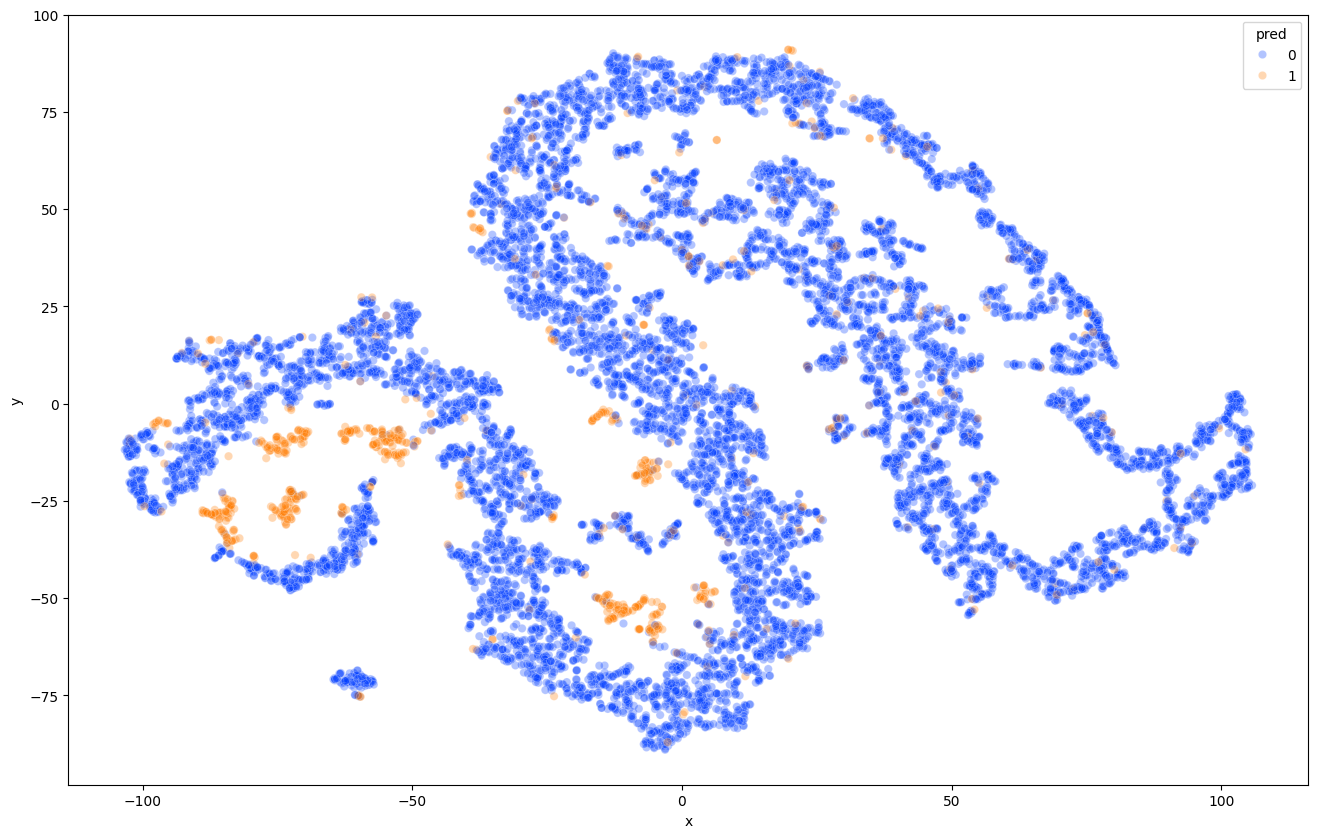

In [32]:
# Plot Ground Truth

# Dimensionality based on USU

labels = g_usu.ndata["label"]
predicted = labels.detach().numpy()

tsne_2d_one = tsne_results[:,0]
tsne_2d_two = tsne_results[:,1]

df = pd.DataFrame({'x':tsne_2d_one, 'y':tsne_2d_two, 'pred':predicted})

# Show the df
# df

# Plot labelling using TSNE
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="pred",
    palette=sns.color_palette("bright", 2),
    data=df,
    legend="full",
    alpha=0.3
)

<ipython-input-33-6de4f797b54d>:14: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


<Axes: xlabel='x', ylabel='y'>

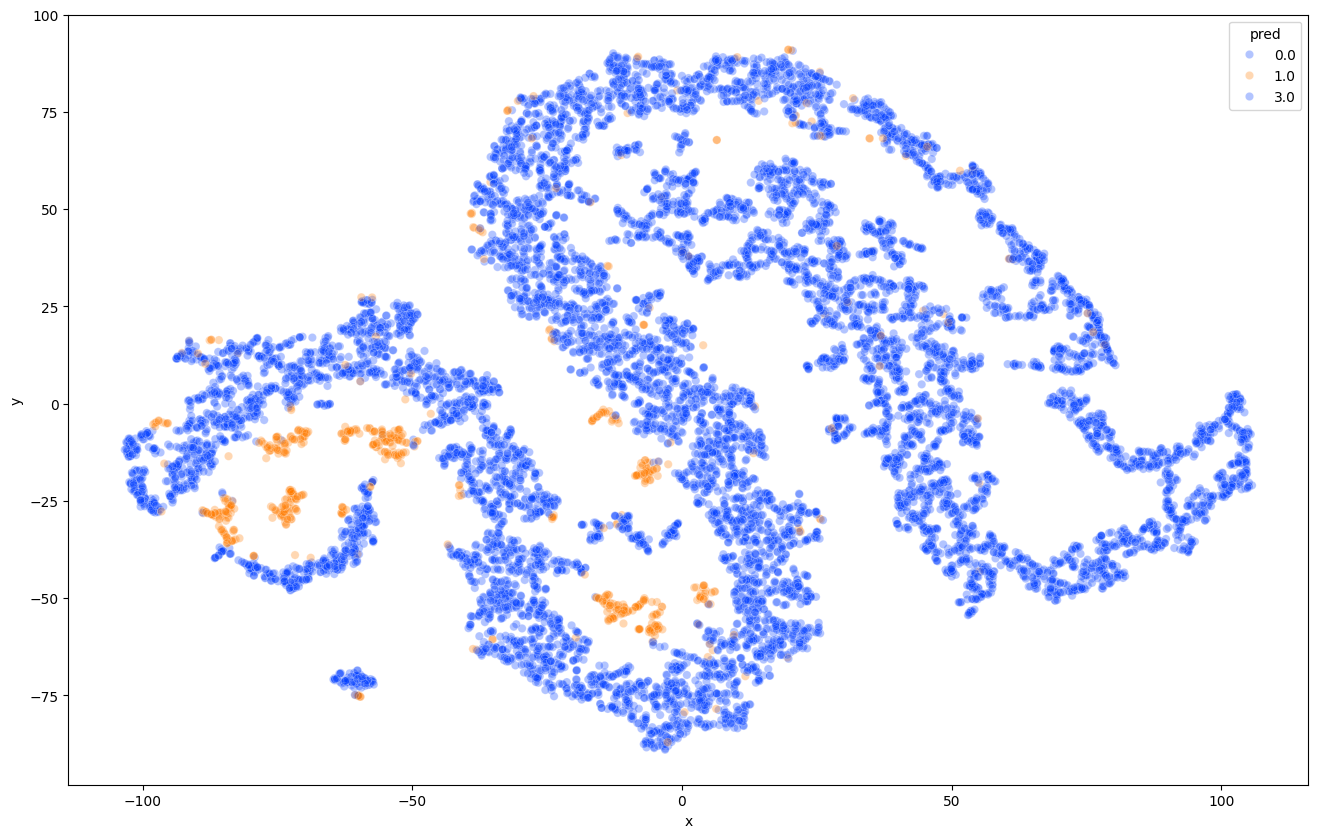

In [33]:
# Plot Insensitive Prediction
predicted = pred_ensemble_insens.detach().numpy()

tsne_2d_one = tsne_results[:,0]
tsne_2d_two = tsne_results[:,1]

df = pd.DataFrame({'x':tsne_2d_one, 'y':tsne_2d_two, 'pred':predicted})

# Show the df
# df

# Plot labelling using TSNE
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="pred",
    palette=sns.color_palette("bright", 2),
    data=df,
    legend="full",
    alpha=0.3
)

<Axes: xlabel='x', ylabel='y'>

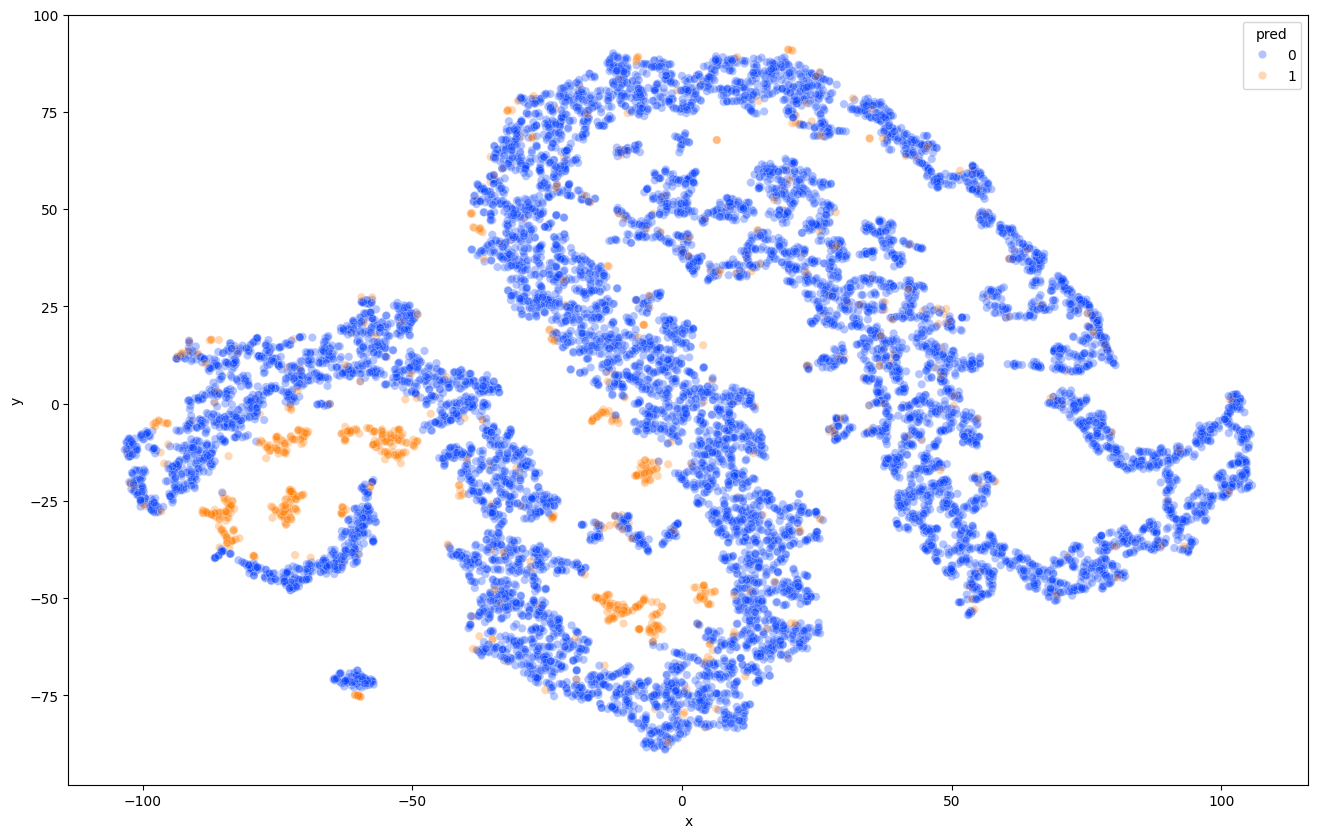

In [34]:
# Plot Sensitive Prediction
predicted = pred_ensemble_sens.detach().numpy()

tsne_2d_one = tsne_results[:,0]
tsne_2d_two = tsne_results[:,1]

df = pd.DataFrame({'x':tsne_2d_one, 'y':tsne_2d_two, 'pred':predicted})

# Show the df
# df

# Plot labelling using TSNE
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="pred",
    palette=sns.color_palette("bright", 2),
    data=df,
    legend="full",
    alpha=0.3
)

<Axes: xlabel='x', ylabel='y'>

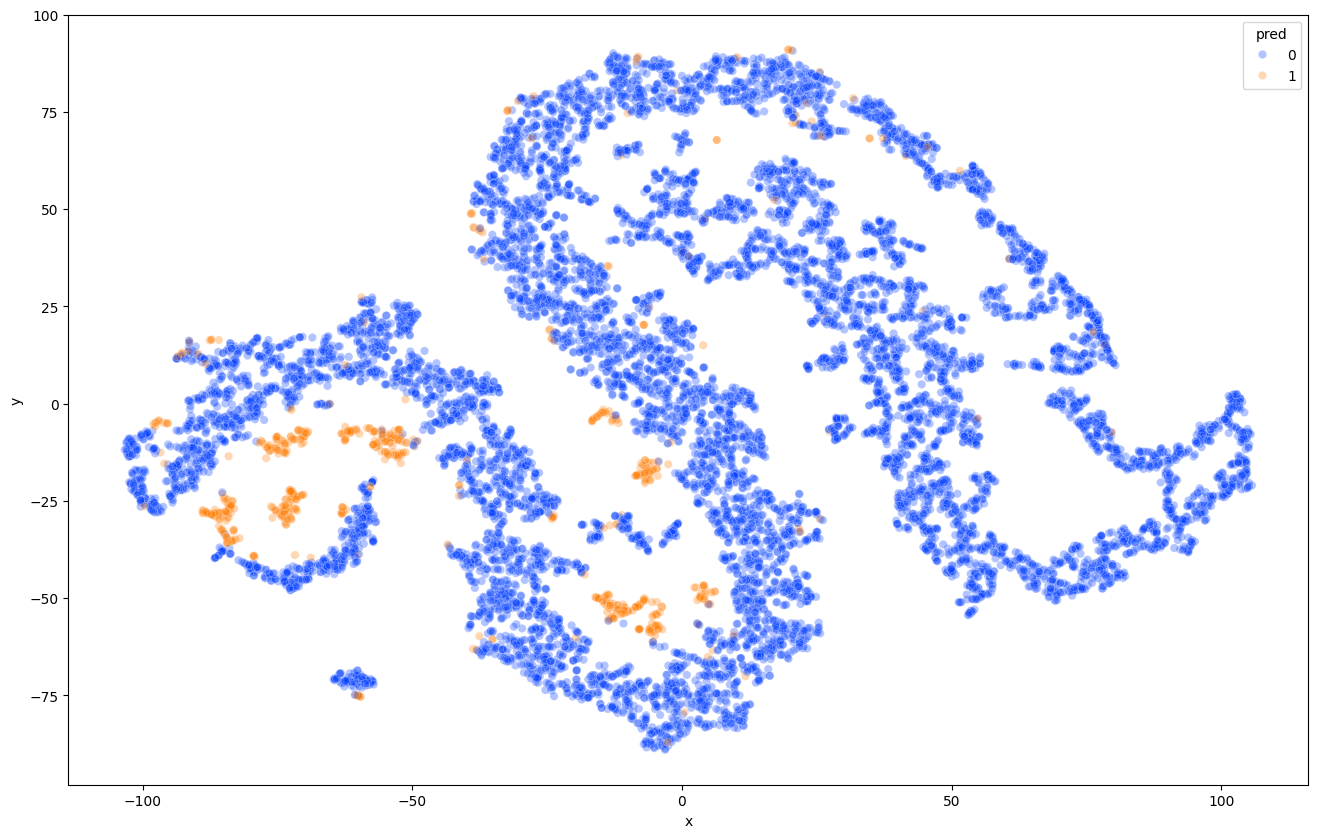

In [35]:
# Plot USU Prediction

# Use USU Data Reduction
predicted = pred_usu.detach().numpy()

df = pd.DataFrame({'x':tsne_2d_one, 'y':tsne_2d_two, 'pred':predicted})

# Show the df
# df

# Plot labelling using TSNE
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="pred",
    palette=sns.color_palette("bright", 2),
    data=df,
    legend="full",
    alpha=0.3
)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11944 samples in 0.001s...
[t-SNE] Computed neighbors for 11944 samples in 1.358s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11944
[t-SNE] Computed conditional probabilities for sample 2000 / 11944
[t-SNE] Computed conditional probabilities for sample 3000 / 11944
[t-SNE] Computed conditional probabilities for sample 4000 / 11944
[t-SNE] Computed conditional probabilities for sample 5000 / 11944
[t-SNE] Computed conditional probabilities for sample 6000 / 11944
[t-SNE] Computed conditional probabilities for sample 7000 / 11944
[t-SNE] Computed conditional probabilities for sample 8000 / 11944
[t-SNE] Computed conditional probabilities for sample 9000 / 11944
[t-SNE] Computed conditional probabilities for sample 10000 / 11944
[t-SNE] Computed conditional probabilities for sample 11000 / 11944
[t-SNE] Computed conditional probabilities for sample 11944 / 11944
[t-SNE] Mean sigma: 7.878257
[t-SNE] KL divergence

<Axes: xlabel='x', ylabel='y'>

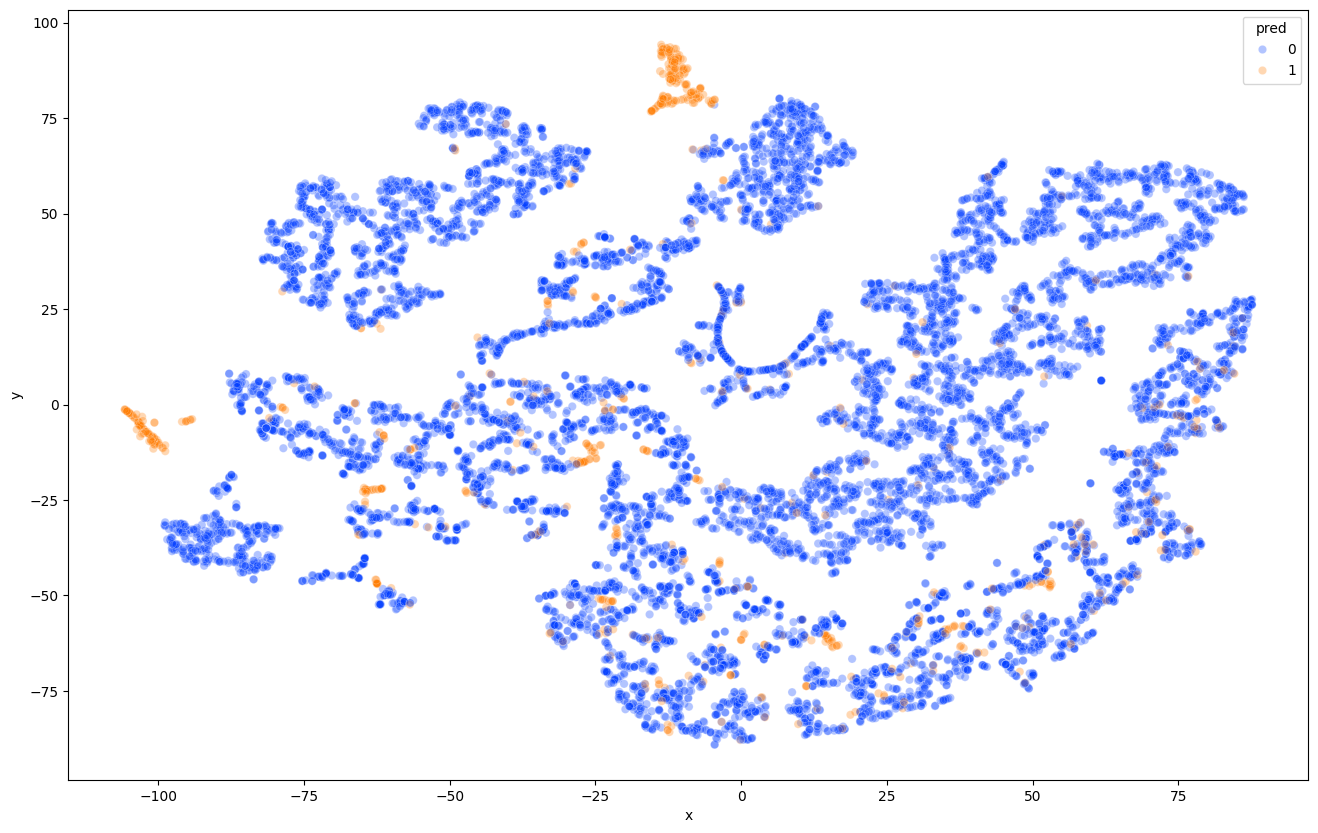

In [36]:
# Plot UPU Prediction

# Create dimension-reduction

# Based on https://builtin.com/data-science/tsne-python
tsne_data = model(g_upu, features).detach().numpy()

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(model(g_upu, features).detach().numpy())

predicted = pred_upu.detach().numpy()

tsne_2d_one = tsne_results[:,0]
tsne_2d_two = tsne_results[:,1]

df = pd.DataFrame({'x':tsne_2d_one, 'y':tsne_2d_two, 'pred':predicted})

# Show the df
# df

# Plot labelling using TSNE
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="pred",
    palette=sns.color_palette("bright", 2),
    data=df,
    legend="full",
    alpha=0.3
)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11944 samples in 0.001s...
[t-SNE] Computed neighbors for 11944 samples in 1.343s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11944
[t-SNE] Computed conditional probabilities for sample 2000 / 11944
[t-SNE] Computed conditional probabilities for sample 3000 / 11944
[t-SNE] Computed conditional probabilities for sample 4000 / 11944
[t-SNE] Computed conditional probabilities for sample 5000 / 11944
[t-SNE] Computed conditional probabilities for sample 6000 / 11944
[t-SNE] Computed conditional probabilities for sample 7000 / 11944
[t-SNE] Computed conditional probabilities for sample 8000 / 11944
[t-SNE] Computed conditional probabilities for sample 9000 / 11944
[t-SNE] Computed conditional probabilities for sample 10000 / 11944
[t-SNE] Computed conditional probabilities for sample 11000 / 11944
[t-SNE] Computed conditional probabilities for sample 11944 / 11944
[t-SNE] Mean sigma: 20.561743
[t-SNE] KL divergenc

<ipython-input-37-2383a210f083>:23: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


<Axes: xlabel='x', ylabel='y'>

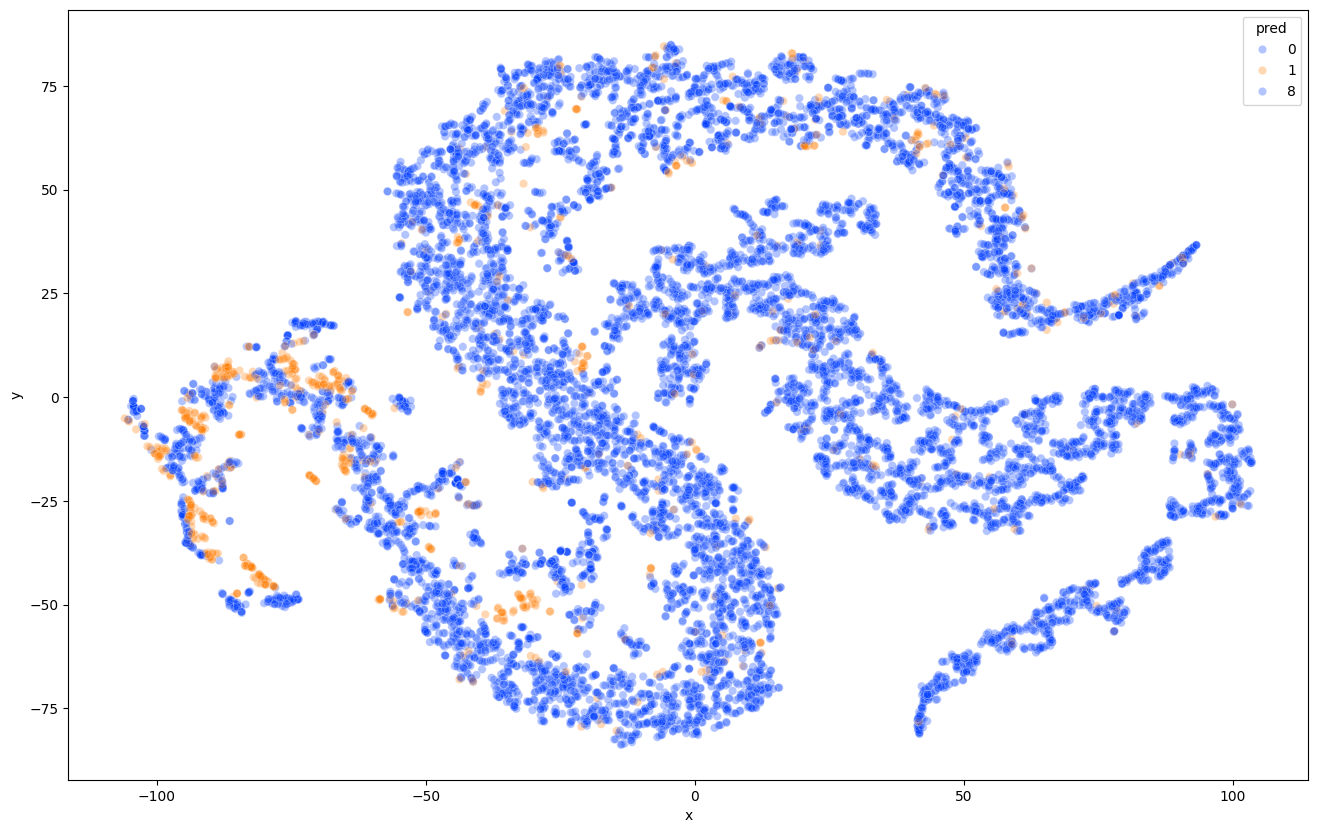

In [37]:
# Plot UVU Prediction

# Create dimension-reduction

# Based on https://builtin.com/data-science/tsne-python
tsne_data = model(g_uvu, features).detach().numpy()

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(model(g_uvu, features).detach().numpy())

predicted = pred_uvu.detach().numpy()

tsne_2d_one = tsne_results[:,0]
tsne_2d_two = tsne_results[:,1]

df = pd.DataFrame({'x':tsne_2d_one, 'y':tsne_2d_two, 'pred':predicted})

# Show the df
# df

# Plot labelling using TSNE
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="pred",
    palette=sns.color_palette("bright", 2),
    data=df,
    legend="full",
    alpha=0.3
)